In [1]:
import os

#데이터셋(Oxford - IIIT pet
##drive에 있는 데이터 꺼내오기

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/images.tar.gz

In [4]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/annotations.tar.gz

In [5]:
cur_dir = os.getcwd()
image_dir = os.path.join(cur_dir,'images')
bbox_dir = os.path.join(cur_dir,'annotations','xmls')
seg_dir = os.path.join(cur_dir,'annotations','trimaps')


In [6]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']#확장자가 jpg인거만
print(len(image_files))#7390개

7390


In [7]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']#확장자가 xml인거만
print(len(bbox_files))#3686개 (모든 이미지에 대해 bound box가 있는건 아님)

3686


In [8]:
seg_files = [fname for fname in os.listdir(seg_dir) if os.path.splitext(fname)[-1] == '.png' and os.path.splitext(fname)[0][0] != '.']#확장자가 png인거만, os.listdir에서 에러가 계속나서 임시방편
print(len(seg_files))#7390개

7390


In [9]:
len(os.listdir(seg_dir))

14780

In [10]:
seg_dir[:30]

'/content/annotations/trimaps'

In [11]:
import random
import numpy as np
from PIL import Image
import xml.etree.ElementTree as et #파싱하려고
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

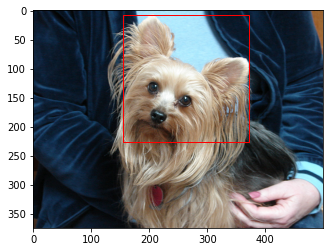

In [16]:
rnd_idx = random.randint(1, len(image_files))
fname = image_files[rnd_idx]
fpath = os.path.join(image_dir,fname)
image = Image.open(fpath)
image = np.array(image)

bbox_name = os.path.splitext(fname)[0] +'.xml'
bbox_path = os.path.join(bbox_dir, bbox_name)
tree = et.parse(bbox_path)

width = float(tree.find('./size/width').text)#xml구조잘 파악하장
height = float(tree.find('./size/height').text)
xmin = float(tree.find('./object/bndbox/xmin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
ymax = float(tree.find('./object/bndbox/ymax').text)

rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

rect = Rectangle((rect_x,rect_y),rect_w,rect_h,fill = False, color = 'red')
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()
#에러나오면 될 때까지 돌려용

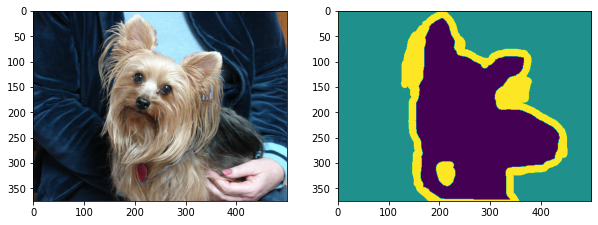

In [17]:
sname = os.path.splitext(fname)[0]+'.png'
spath = os.path.join(seg_dir, sname)
seg = Image.open(spath)
seg = np.array(seg)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(seg)
plt.show()

In [19]:
!nvidia-smi

Sun Aug 16 14:25:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import re
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt

###버전확인


In [22]:
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


In [24]:
#image file중 channel이 3이 아니면 삭제
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(image_file, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(image_path)
#channel 4개 혹은 흑백이미지 삭제

Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_145.jpg P
(188, 216)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_167.jpg P
(275, 183)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_129.jpg L
(325, 299)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_139.jpg P
(250, 350)


In [25]:
#이미지 중 channel 3개 아닌거 다삭제하고 갯수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))#7378

7378


In [26]:
#집합으로 이름을 정리
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+','',file_name)#뒤에 숫자 pug_111같은거에서 삭제
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [27]:
#정렬
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [28]:
class_list[1]

'Bengal'

In [30]:
class2idx = {cls:idx for idx,cls in enumerate(class_list)}#딕셔너리로 만들어서 one-hot encoding쉽게하자
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [32]:
#train,validation 나누기
train_dir = os.path.join(cur_dir, 'train')
val_dir = os.path.join(cur_dir, 'validation')
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)

In [33]:
image_files.sort()

In [34]:
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [35]:
#160번까지는 train_dir로, 그 이상은 val_dir로

cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+','',file_name)
    if class_name == previous_class:
        cnt+=1
    else:
        cnt = 1
    if cnt<=160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name        

In [40]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

In [41]:
print(len(train_images),len(val_images))#나눠줬당.

5920 1458


In [44]:
train_images[:10]

['yorkshire_terrier_178.jpg',
 'Maine_Coon_164.jpg',
 'chihuahua_53.jpg',
 'Birman_136.jpg',
 'Bombay_186.jpg',
 'japanese_chin_43.jpg',
 'havanese_122.jpg',
 'Russian_Blue_43.jpg',
 'german_shorthaired_169.jpg',
 'great_pyrenees_100.jpg']

In [45]:
val_images[:10]

['boxer_95.jpg',
 'Persian_79.jpg',
 'keeshond_7.jpg',
 'havanese_86.jpg',
 'scottish_terrier_92.jpg',
 'american_pit_bull_terrier_9.jpg',
 'Persian_90.jpg',
 'Birman_7.jpg',
 'chihuahua_80.jpg',
 'Birman_63.jpg']

#TFrecord file 만들기


In [46]:
IMG_SIZE = 224

In [47]:
#tfreord저장할곳
#tfrecord file이란 tf를 위한 바이너리 파일 파이프라인 자동 구성됨.
tfr_dir = os.path.join(cur_dir,'tfrecord')
os.makedirs(tfr_dir,exist_ok=True)

tfr_train_dir=os.path.join(tfr_dir,'cls_train.tfr')
tfr_val_dir=os.path.join(tfr_dir,'cls_val.tfr')

In [48]:
#tfrecord writer생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [49]:
#tensorflow 듀토리얼에서 긁어옴.
# https://www.tensorflow.org/tutorials/load_data/tfrecord
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [53]:
#training -> tfrecord
n_train = 0#개수확인용

train_files = os.listdir(train_dir)
for train_file in train_files:
    train_path = os.path.join(train_dir, train_file)
    image = Image.open(train_path)
    image = image.resize((IMG_SIZE,IMG_SIZE))
    bimage = image.tobytes()

    file_name = os.path.splitext(train_file)[0]
    class_name = re.sub('_\d+','',file_name)
    class_num = class2idx[class_name]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(class_num)
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1

writer_train.close()
print(n_train)

5920


In [56]:
#validation -> tfrecord
n_val = 0#개수확인용

val_files = os.listdir(val_dir)
for val_file in val_files:
    val_path = os.path.join(val_dir, val_file)
    image = Image.open(val_path)
    image = image.resize((IMG_SIZE,IMG_SIZE))
    bimage = image.tobytes()

    file_name = os.path.splitext(val_file)[0]
    class_name = re.sub('_\d+','',file_name)
    class_num = class2idx[class_name]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(class_num)
    }))
    writer_val.write(example.SerializeToString())
    n_val += 1

writer_val.close()
print(n_val)

1458


In [57]:
!ls -l $tfr_dir

total 1085016
-rw-r--r-- 1 root root 891486880 Aug 16 15:05 cls_train.tfr
-rw-r--r-- 1 root root 219558762 Aug 16 15:07 cls_val.tfr


#Classification

##하이퍼파라미터

In [58]:
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN/N_BATCH#1480
validation_steps = int(np.ceil(N_VAL/N_BATCH))#37

In [59]:
#tfrecord를 data로 parsing
def _parse_function(tfrecord_serialized):
    features={'image':tf.io.FixedLenFeature([],tf.string),
              'cls_num':tf.io.FixedLenFeature([],tf.int64)
              }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)#요래 생겼어!! 알려줌

    image = tf.io.decode_raw(parsed_features['image'],tf.uint8)
    image = tf.reshape(image, [IMG_SIZE,IMG_SIZE, 3])
    image = tf.cast(image,tf.float32)/255.0

    label = tf.cast(parsed_features['cls_num'],tf.int64)

    return image,label

In [60]:
#train_dataset
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [62]:
#val_dataset
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

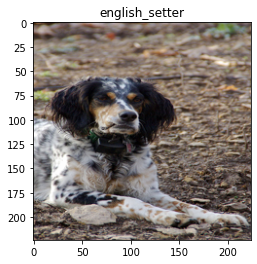

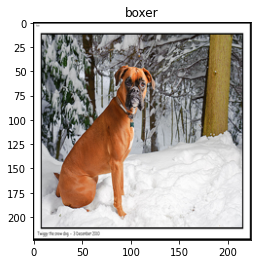

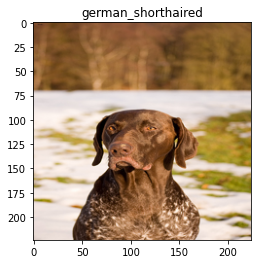

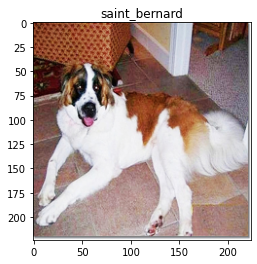

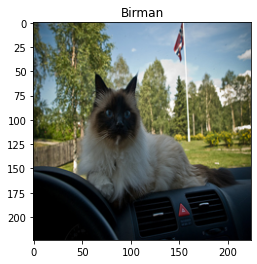

In [67]:
#잘 되었니..?
for image, label in train_dataset.take(5):
    plt.imshow(image[0])#각 배치의 첫번째꺼를 보자
    title = class_list[label[0].numpy()]
    plt.title(title)
    plt.show()

In [77]:
#이번엔 sequential api 사용
def MyModel():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32,3,activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(64,3,activation='relu',padding='same'))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(128,3,activation='relu',padding='same'))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(256,3,activation='relu',padding='same'))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(256,3,activation='relu',padding='same'))
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024,activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))

    return model

In [78]:
model = MyModel()

model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 256)      

In [79]:
history = model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_dataset,
    validation_steps = validation_steps
)

Epoch 1/20
148/148 [==============================] - 14s 92ms/step - loss: 3.5914 - accuracy: 0.0350 - val_loss: 3.4897 - val_accuracy: 0.0768
Epoch 2/20
148/148 [==============================] - 13s 91ms/step - loss: 3.3241 - accuracy: 0.1003 - val_loss: 3.1444 - val_accuracy: 0.1420
Epoch 3/20
148/148 [==============================] - 13s 91ms/step - loss: 3.0350 - accuracy: 0.1693 - val_loss: 2.9727 - val_accuracy: 0.1708
Epoch 4/20
148/148 [==============================] - 13s 91ms/step - loss: 2.7937 - accuracy: 0.2242 - val_loss: 2.8772 - val_accuracy: 0.2051
Epoch 5/20
148/148 [==============================] - 13s 90ms/step - loss: 2.5827 - accuracy: 0.2784 - val_loss: 2.7886 - val_accuracy: 0.2112
Epoch 6/20
148/148 [==============================] - 13s 91ms/step - loss: 2.3245 - accuracy: 0.3431 - val_loss: 2.8356 - val_accuracy: 0.2160
Epoch 7/20
148/148 [==============================] - 14s 91ms/step - loss: 2.0340 - accuracy: 0.4176 - val_loss: 2.7733 - val_accuracy:

In [81]:
#위에거 너무 오바여서 batch norm 넣는다.
def MyModel2():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32,3,padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(64,3,padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(128,3,padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(256,3,padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Conv2D(256,3,padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D((2,2),padding='same'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))

    return model

In [84]:
model = MyModel()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = learning_rate,
                                                         decay_steps = steps_per_epoch,#epoch마다
                                                         decay_rate = 0.5,
                                                         staircase=True)

model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 112, 112, 64)     

In [85]:
history = model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_dataset,
    validation_steps = validation_steps
)
#큰 차이는 없당..dropout만 썼을 때 보단 났다.

Epoch 1/20
148/148 [==============================] - 18s 124ms/step - loss: 3.1850 - accuracy: 0.1613 - val_loss: 4.9690 - val_accuracy: 0.0274
Epoch 2/20
148/148 [==============================] - 18s 123ms/step - loss: 1.5538 - accuracy: 0.6304 - val_loss: 5.1198 - val_accuracy: 0.0274
Epoch 3/20
148/148 [==============================] - 18s 121ms/step - loss: 0.8440 - accuracy: 0.8799 - val_loss: 3.5338 - val_accuracy: 0.1097
Epoch 4/20
148/148 [==============================] - 18s 121ms/step - loss: 0.5821 - accuracy: 0.9515 - val_loss: 2.8600 - val_accuracy: 0.2195
Epoch 5/20
148/148 [==============================] - 18s 122ms/step - loss: 0.4707 - accuracy: 0.9777 - val_loss: 2.6823 - val_accuracy: 0.2579
Epoch 6/20
148/148 [==============================] - 18s 121ms/step - loss: 0.4246 - accuracy: 0.9831 - val_loss: 2.6696 - val_accuracy: 0.2647
Epoch 7/20
148/148 [==============================] - 18s 121ms/step - loss: 0.4036 - accuracy: 0.9851 - val_loss: 2.6689 - val_ac

#MobileNetV2 전이학습 할거임. 

##depthwise, pointwise convolution
##inverted residual(narrow->wide->narrow하고 narrow랑 narrow랑 sum)로 skip connection
##linear bottleneck(activation안함)